### Ozone Object Instantiation

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from src.ozone import Ozone

pwv = 0.5
zenith = 1

data_path = '/Users/namsonnguyen/repo/data/AM_Data/newdata2/'
my_ozone = Ozone(am_model_data_path=data_path)
spectrum = my_ozone(pwv, zenith)


AssertionError: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from src.ozone import Ozone

pwv = 0.5
zenith = 1

data_path = '/Users/namsonnguyen/repo/data/AM_Data/newdata2/'
my_ozone = Ozone(am_model_data_path=data_path)
spectrum, pwv_jacobian = my_ozone(pwv, zenith, return_pwv_jacobian=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7), sharex=True, sharey=True)

freq_channels = np.linspace(180, 420, my_ozone.data['freq']['points'])
ax1.set_title(r"T$_b$ Spectrum" + f" (PWV={pwv} mm; zenith={zenith:.2f} rad)")
ax1.plot(freq_channels, spectrum[0,0])
ax1.set_ylabel(r'T$_b$ [K]')
ax1.set_xlim(min(freq_channels), max(freq_channels));

ax2.plot(freq_channels, pwv_jacobian)
ax2.set_title(f"Jacobian w.r.t. PWV (PWV={pwv} mm; zenith={zenith:.2f} rad)")
ax2.set_ylabel(r'$\partial$T$_b$ / $\partial$PWV [K/mm]')
fig.supxlabel('Frequency [GHz]')
ax2.set_xlim(min(freq_channels), max(freq_channels));
ax2.set_ylim(0, 100)

AssertionError: 

In [5]:
%%timeit
my_ozone = Ozone(am_model_data_path=data_path)

769 ms ± 89.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
%%timeit
# post efficiency change
my_ozone = Ozone(am_model_data_path=data_path)

837 ms ± 84.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
%%timeit
spectrum, pwv_jacobian, __ = my_ozone(pwv, zenith)

184 ms ± 2.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
%%timeit
# post efficiency change
spectrum, pwv_jacobian, __ = my_ozone(pwv, zenith, return_pwv_jacobian=True)

166 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%%timeit
# post efficiency change
spectrum, __, __ = my_ozone(pwv, zenith)

145 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
%%timeit
# post efficiency change
__, pwv_jacobian, __ = my_ozone(pwv, zenith, return_pwv_jacobian=True, return_model_spectrum=False)

21.3 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%%timeit
# post efficiency change
__, __, zenith_jacobian = my_ozone(pwv, zenith, return_zenith_jacobian=True, return_model_spectrum=False)

20.6 ms ± 483 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


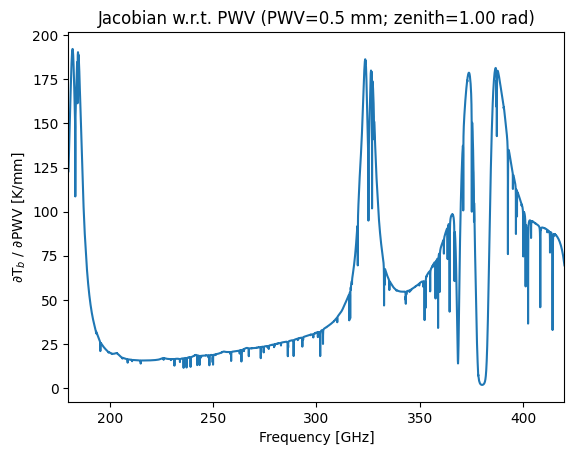

In [9]:
plt.plot(freq_channels, pwv_jacobian)
plt.title(f"Jacobian w.r.t. PWV (PWV={pwv} mm; zenith={zenith:.2f} rad)")
plt.ylabel(r'$\partial$T$_b$ / $\partial$PWV [K/mm]')
plt.xlabel('Frequency [GHz]')
plt.xlim(min(freq_channels), max(freq_channels));

### Nscale Regular Grid Interpolator

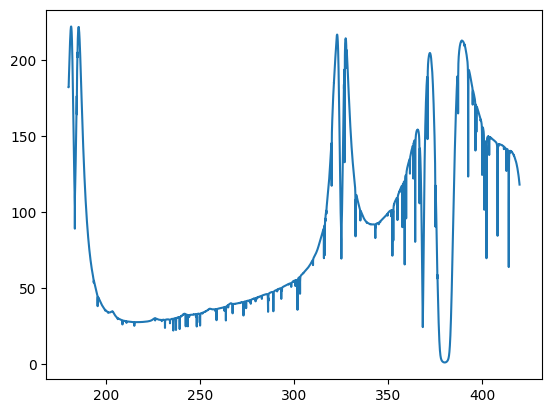

In [10]:
from scipy.interpolate import RegularGridInterpolator

interp_func = RegularGridInterpolator(
    points=(my_ozone.data['Nscale']['map'], my_ozone.data['airmass']['map'], my_ozone.data['freq']['map']), 
    values=my_ozone.data['Nscale']['jacobian'], method="linear"
)

nominal_pwv = my_ozone._extract_nominal_pwv()
pwv = 1
nscale = np.log10(pwv / nominal_pwv)

zenith = np.radians(45)
airmass = my_ozone._zenith_to_airmass(zenith)

x,y,z = np.meshgrid(nscale, airmass, my_ozone.data['freq']['map'], indexing='ij')

spectrum = interp_func((x.flatten(),y.flatten(),z.flatten())).reshape(x.shape)[0,0]
freq_channels = np.linspace(180, 420, my_ozone.data['freq']['points'])

plt.plot(freq_channels, spectrum)


### Airmass Regular Grid Interpolator

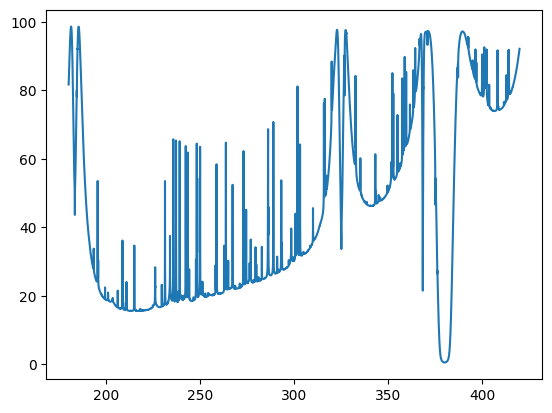

In [11]:
from scipy.interpolate import RegularGridInterpolator

interp_func = RegularGridInterpolator(
    points=(my_ozone.data['Nscale']['map'], my_ozone.data['airmass']['map'], my_ozone.data['freq']['map']), 
    values=my_ozone.data['airmass']['jacobian'], method="linear"
)

nominal_pwv = my_ozone._extract_nominal_pwv()
pwv = 1
nscale = np.log10(pwv / nominal_pwv)

zenith = np.radians(45)
airmass = my_ozone._zenith_to_airmass(zenith)

x,y,z = np.meshgrid(nscale, airmass, my_ozone.data['freq']['map'], indexing='ij')

spectrum = interp_func((x.flatten(),y.flatten(),z.flatten())).reshape(x.shape)[0,0]

normalization_factor = (1/np.cos(zenith))*np.tan(zenith)
spectrum = spectrum * normalization_factor

freq_channels = np.linspace(180, 420, my_ozone.data['freq']['points'])

plt.plot(freq_channels, spectrum)

### AM-run script

In [1]:
from src.ozone import Ozone

data_path = '/Users/namsonnguyen/repo/data/AM_Data/SON50_w_opacity/'

my_ozone = Ozone(am_model_data_path=data_path)
data = my_ozone.data

(-0.002, 0.002)

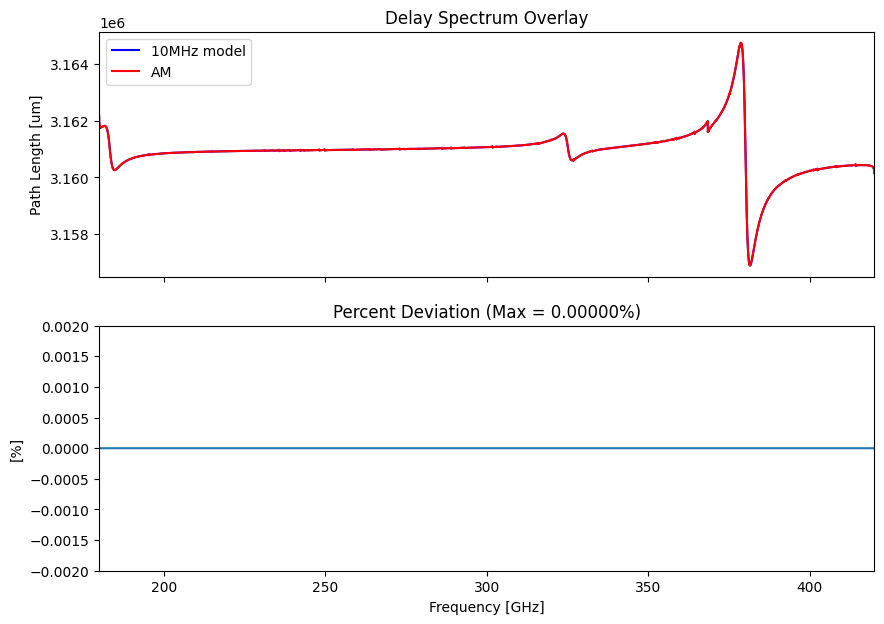

In [33]:
import numpy as np
import matplotlib.pyplot as plt

lognscale = data['Nscale']['map'][4] + (data['Nscale']['map'][5]-data['Nscale']['map'][4])
pwv = np.exp(lognscale) * my_ozone.nominal_pwv
logairmass = data['airmass']['map'][4] + (data['airmass']['map'][5]-data['airmass']['map'][4])
zenith = my_ozone._airmass_to_zenith(np.exp(logairmass))

L_spectrum = my_ozone.delay_spectrum(pwv, zenith)

fig, ax = plt.subplots(2, sharey=False, sharex=True, figsize=(10, 7))

freq_channels = data['freq']['L_map']
freq_range = (210, 240)
freq_range = (180, 420)
freq_mask = (freq_channels >= freq_range[0]) & (freq_channels <= freq_range[1])
ax[0].plot(freq_channels[freq_mask], L_spectrum[freq_mask], c='blue')
#print(L_spectrum.shape)

### AM Midpoint Comparison

model_interval = 10
am_interval = 10
am_data = np.load(f'/Users/namsonnguyen/repo/data/AM_Data/SON50_delay_spectra_{am_interval}MHz/MaunaKea_Delay_Spectrum_{logairmass:.3f}_{lognscale:.3f}.out')
freq_channels = am_data[:,0]
freq_range = (210, 240)
freq_range = (180, 420)
AM_freq_mask = (freq_channels >= freq_range[0]) & (freq_channels <= freq_range[1])
am_delay_spectrum = am_data[:,1]

ax[0].plot(freq_channels[AM_freq_mask], am_delay_spectrum[AM_freq_mask], c='red')
#print(am_delay_spectrum.shape)

#print(freq_mask.shape, AM_freq_mask.shape)

norm_factor = int(am_interval/model_interval)
#print(norm_factor)
norm_factor = 1 if norm_factor==0 else norm_factor

difference_spectrum = ((L_spectrum[freq_mask][::norm_factor] - am_delay_spectrum[AM_freq_mask]) / am_delay_spectrum[AM_freq_mask]) * 100
percentile_50, percentile_99 = np.percentile(difference_spectrum, [50, 99])
ax[1].plot(freq_channels[AM_freq_mask], difference_spectrum)

ax[0].legend([f'{am_interval}MHz model', 'AM'])
ax[0].set_title('Delay Spectrum Overlay')
ax[1].set_title(f"Percent Deviation (Max = {percentile_99:.5f}%)")
ax[1].set_xlabel('Frequency [GHz]')
ax[0].set_ylabel('Path Length [um]')
ax[1].set_ylabel('[%]')
plt.xlim(180, 420) #(210, 240)
plt.ylim(-0.002, 0.002)

(240001, 7) (24001, 4)


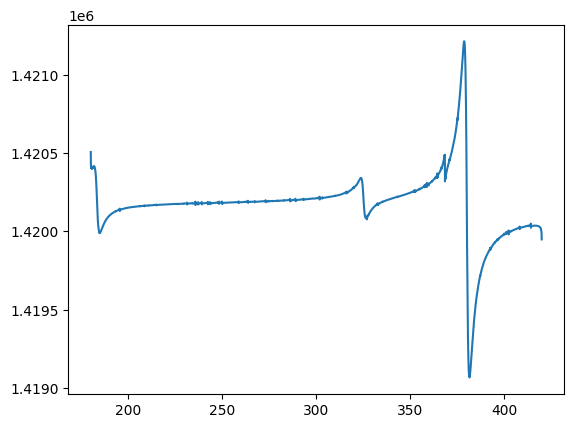

In [24]:
import matplotlib.pyplot as plt

old_spectrums = np.load('/Users/namsonnguyen/repo/data/AM_Data/SON50_w_opacity/MaunaKea_Tb_Spectrum_0.001_-0.250.out')
new_spectrums = np.load('/Users/namsonnguyen/repo/data/AM_Data/SON50_delay_spectra_10MHz/MaunaKea_Delay_Spectrum_0.001_-0.250.out')

print(old_spectrums.shape, new_spectrums.shape)

freq_range = (180, 420) #(210, 240)
old_freq_channels = old_spectrums[:,0]
old_freq_mask = (old_freq_channels >= freq_range[0]) & (old_freq_channels <= freq_range[1])
new_freq_channels = new_spectrums[:,0]
new_freq_mask = (new_freq_channels >= freq_range[0]) & (new_freq_channels <= freq_range[1])

#plt.plot(old_freq_channels[old_freq_mask], old_spectrums[old_freq_mask,6])
plt.plot(new_freq_channels[new_freq_mask], new_spectrums[new_freq_mask,1])
# new - delay spectra is index 

In [8]:
import src.utils as utils

import numpy as np
start_logairmass = 0.001
start_logNscale = -2.0

second_logairmass = 0.041
second_logNscale = -1.875

end_logairmass = 1.281
end_logNscale = 2.0

interval_logairmass = np.abs(second_logairmass-start_logairmass)
interval_logNscale = np.abs(second_logNscale - start_logNscale)

width_logairmass = int((end_logairmass - start_logairmass)/interval_logairmass)+1
width_logNscale = int((end_logNscale - start_logNscale)/interval_logNscale)+1

logairmass_map = np.linspace(start_logairmass, end_logairmass, width_logairmass)
lognscale_map = np.linspace(start_logNscale, end_logNscale, width_logNscale)

##################################################

zenith_map = my_ozone._airmass_to_zenith(np.exp(logairmass_map))
za_units = 'rad'

script_path = 'test'
outpath = '/Users/namsonnguyen/repo/data/AM_data/SON50_delay_spectra'
am_path = '/Users/namsonnguyen/repo/am-14.0/src/am'
am_model = 'MaunaKea_SON_50.amc'

freq_start = 180 #210
freq_end = 420 #240
freq_interval = 200

for ZA, airmass in zip(zenith_map, logairmass_map):
    for nscale in lognscale_map:
        script = f"""
        {am_path} {am_model} \
        {freq_start} GHz {freq_end} GHz 10 MHz {ZA} rad 277 K {np.exp(nscale)} \
        > {outpath}/MaunaKea_Delay_Spectrum_{airmass:.3f}_{nscale:.3f}.out \
        2> {outpath}/MaunaKea_Delay_Spectrum_{airmass:.3f}_{nscale:.3f}.err
        """

        utils.run_AM(script_path, outpath, airmass, ZA, nscale, za_units, freq_start, freq_end, script)

Starting am for AM=0.001 (ZA=2.6 deg); nscale=-2.00
Starting am for AM=0.001 (ZA=2.6 deg); nscale=-1.88
Starting am for AM=0.001 (ZA=2.6 deg); nscale=-1.75
Starting am for AM=0.001 (ZA=2.6 deg); nscale=-1.62
Starting am for AM=0.001 (ZA=2.6 deg); nscale=-1.50
Starting am for AM=0.001 (ZA=2.6 deg); nscale=-1.38
Starting am for AM=0.001 (ZA=2.6 deg); nscale=-1.25
Starting am for AM=0.001 (ZA=2.6 deg); nscale=-1.12
Starting am for AM=0.001 (ZA=2.6 deg); nscale=-1.00
Starting am for AM=0.001 (ZA=2.6 deg); nscale=-0.88
Starting am for AM=0.001 (ZA=2.6 deg); nscale=-0.75
Starting am for AM=0.001 (ZA=2.6 deg); nscale=-0.62
Starting am for AM=0.001 (ZA=2.6 deg); nscale=-0.50
Starting am for AM=0.001 (ZA=2.6 deg); nscale=-0.38
Starting am for AM=0.001 (ZA=2.6 deg); nscale=-0.25
Starting am for AM=0.001 (ZA=2.6 deg); nscale=-0.12
Starting am for AM=0.001 (ZA=2.6 deg); nscale=0.00
Starting am for AM=0.001 (ZA=2.6 deg); nscale=0.12
Starting am for AM=0.001 (ZA=2.6 deg); nscale=0.25
Starting am for

# T*_sys Function

In [1]:
from src.ozone import Ozone
import numpy as np
import matplotlib.pyplot as plt

data_path = '/Users/namsonnguyen/repo/data/AM_Data/SON50_w_opacity/'

my_ozone = Ozone(am_model_data_path=data_path)
data = my_ozone.data
freq_range = (210, 240)
freq_channels = my_ozone.data['freq']['map']
freq_mask = (freq_channels >= freq_range[0]) & (freq_channels <= freq_range[1])

In [3]:
pwv=5
ZA=1
Trx = 40   # K

t_star, Tsky, tau = my_ozone.calc_t_star(pwv, ZA, Trx, return_Tsky=True, return_tau=True)

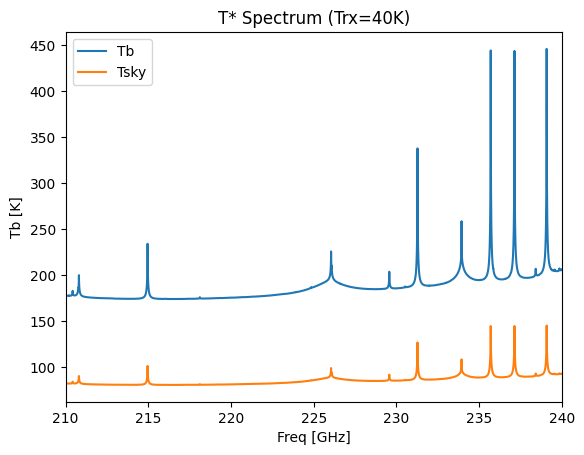

In [4]:
plt.plot(freq_channels[freq_mask], (Trx+Tsky[freq_mask])/np.exp(-tau[freq_mask]))
plt.plot(freq_channels[freq_mask], Tsky[freq_mask])

plt.title(f'T* Spectrum (Trx={Trx}K)')
plt.ylabel('Tb [K]')
plt.xlabel('Freq [GHz]')
plt.xlim(freq_range)
plt.legend(['Tb', 'Tsky'])

Text(0.5, 0, 'Freq [GHz]')

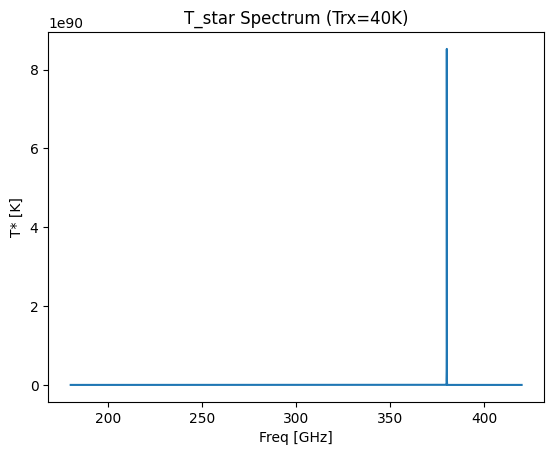

In [5]:
plt.plot(freq_channels, t_star)

plt.title(f'T_star Spectrum (Trx={Trx}K)')
plt.ylabel('T* [K]')
plt.xlabel('Freq [GHz]')
#plt.xlim(freq_range)

Text(0.5, 0, 'Freq [GHz]')

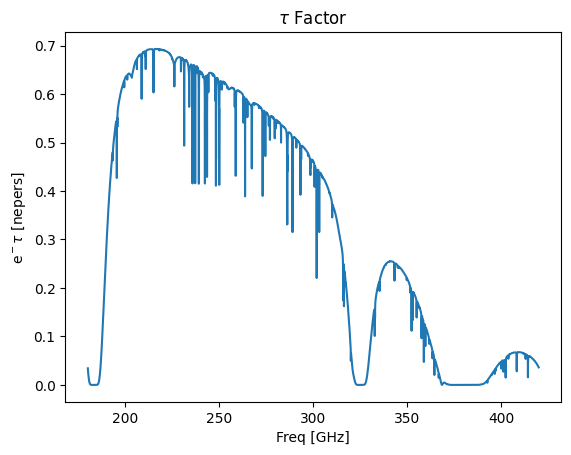

In [6]:
plt.plot(freq_channels, np.exp(-tau))

plt.title(r'$\tau$ Factor')
plt.ylabel(r'e$^-\tau$ [nepers]')
plt.xlabel('Freq [GHz]')